# Application of k-means to weather data

This notebook example is adapted from [Dr. Elizabeth A. Barnes's Objective Analysis for the Atmospheric Sciences (Colorado State University)](https://github.com/eabarnes1010/course_objective_analysis/tree/main).

Here we show an example of calculating k-means clustering analysis on wintertime (December-January-February) North American daily anomalous surface temperature. The clusters will each be a map of anomalous surface temperatures over North America. We will use [the clustering package from SciPy](https://docs.scipy.org/doc/scipy/reference/cluster.vq.html).

### Load the modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from scipy.cluster.vq import kmeans,vq
import scipy.io as sio
import xarray as xr
import numpy.ma as ma

import seaborn as sns # statistical data visualization
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import cartopy as ct
import cartopy.crs as ccrs
import cmocean as cmocean # colormaps for commonly-used oceanographic variables

mpl.rcParams['figure.dpi']= 100
CL = 0.
mapProj = ct.crs.PlateCarree(central_longitude = CL)

In [2]:
# set random seed so we get identical results every time
%env PYTHONHASHSEED=99
np.random.seed(99)

env: PYTHONHASHSEED=99


### Plotting Functions

In [3]:
def drawOnGlobe(ax, data, lats, lons, cmap='coolwarm', vmin=None, vmax=None, inc=None, cbarBool=True, contourMap=[], contourVals = [], fastBool=False, extent='both'):

    data_crs = ct.crs.PlateCarree()

    ax.set_global()
    ax.coastlines(linewidth = 1.2, color='black')
    if(fastBool):
        image = ax.pcolormesh(lons, lats, data, transform=data_crs, cmap=cmap)
    else:
        image = ax.pcolor(lons, lats, data, transform=data_crs, cmap=cmap)
    
    if(np.size(contourMap) !=0 ):
        ax.contour(lons,lats,contourMap,contourVals, transform=data_crs, colors='fuchsia')
    
    if(cbarBool):
        cb = plt.colorbar(image, shrink=.75, orientation="vertical", pad=.02, extend=extent)
        cb.ax.tick_params(labelsize=6) 
    else:
        cb = None

    image.set_clim(vmin,vmax)
    
    return cb, image  


### Load in the data

_Data Description:_

20 years of wintertime (December-February) North American daily anomalous surface temperature from a model simulation. The daily data has had a 7-day low-pass filter applied, and has been weighted for this analysis.

In [4]:
import pooch

doi = "doi:10.5281/zenodo.14174136"
fname = "tas_DJFdays_PAMIP_CESM2_NorthAmerica.nc"
filename = pooch.retrieve(
    url=f"{doi}/{fname}",
    known_hash="md5:6d5e69c4e4dcff6afbcb49e6ba7b5b29",
)

da = xr.open_dataset(filename)
data = da['__xarray_dataarray_variable__'].values
lat = da['latitude']
lon = da['longitude']
(lon.shape, lat.shape, data.shape)

((61,), (45,), (1800, 45, 61))

### K-means

The k-means algorithm and code is similar to the geyser example.

You are going to run the k-means algorithm for three different numbers of clusters (ex. 4, 6, and 9 clusters) and compare the outputs. Note that this algorithm does take some time to run, especially for large numbers of iterations.

In [8]:
# kmeans?

### choose parameters and run clustering algorithm

In [5]:
#----------- MODIFY -------------------------
numclust = 6            # number of clusters to fit
n_iters_vec = [20,]     # number of full iterations run, then take the best one
#--------------------------------------------

dist_vec = np.asarray([])
for n_iters in n_iters_vec:
    # syntax: clusters/nodes/centroids, sum distance/quantization error = kmeans(input data, #clusters, #iterations) 
    clusters, dist = kmeans(data.reshape(data.shape[0],data.shape[1]*data.shape[2]), numclust, iter=n_iters)
    classes, _ = vq(data.reshape(data.shape[0],data.shape[1]*data.shape[2]),clusters)

    dist_vec = np.append(dist_vec,dist)
    
print('clusters shape = ' + str(clusters.shape))
print('classes shape = ' + str(classes.shape))    

clusters shape = (6, 2745)
classes shape = (1800,)


### plot the clusters

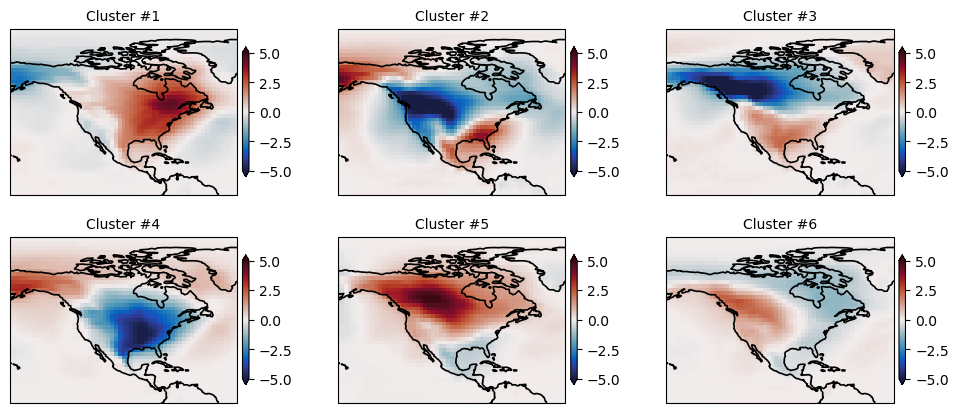

In [6]:
maxVal = 5.
titleSize = 10
cmap = cmocean.cm.balance
fastBool = True

extent = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)]

plt.figure(figsize=(8*1.5,5*1.5*.66))

for cluster in np.arange(0,numclust):
    ax = plt.subplot(2,int(np.ceil(numclust/2.)),cluster+1,projection=mapProj)
    xplot = clusters[cluster,:].reshape(len(lat),len(lon))
    cb, image = drawOnGlobe(ax, xplot, np.squeeze(lat), np.squeeze(lon), cmap=cmap, vmin = -maxVal, vmax=maxVal, cbarBool=True, fastBool=fastBool)
    ax.set_extent(extent)
    cb.set_label('', fontsize=titleSize)
    cb.ax.tick_params(labelsize=titleSize) 
    plt.title('Cluster #' + str(cluster+1), fontsize=titleSize)

plt.show()

Some of the clusters resemble the positive and negative phases of the [North Atlantic Oscillation](https://www.climate.gov/news-features/understanding-climate/climate-variability-north-atlantic-oscillation).

### summarize cluster labels

For this I will plot a frequency diagram of how often each cluster happens.

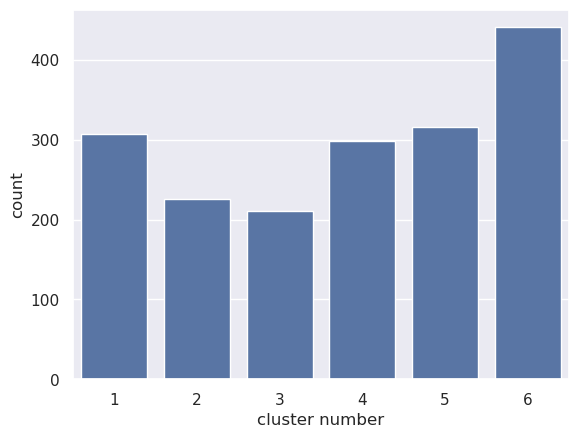

In [7]:
da_classes = pd.DataFrame(data={'class':classes+1})

sns.set(style="darkgrid")
ax = sns.countplot(data=da_classes,x='class')
plt.xlabel('cluster number')
plt.show()